# Natural Language Processing with Disaster Tweets

https://www.kaggle.com/c/nlp-getting-started/data

In [1]:
import numpy as np
import os
import pandas as pd


data_fp = os.path.join(os.getcwd(), "data")
train_fp = os.path.join(data_fp, "train.csv")
train_full = pd.read_csv(train_fp, encoding="utf-8")
test_fp = os.path.join(data_fp, "test.csv")
test = pd.read_csv(test_fp, encoding="utf-8")

print(f"Train: {train_full.shape}")
print(f"Test:  {test.shape}")

train_full.head()

Train: (7613, 5)
Test:  (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Kaggle supplies the test set (without target labels), so we will submit our final predictions there to get the ultimate measure of model performance. We separate 20% of the training data as a validation set.

In [2]:
# Shuffle the index in case there are patterns in the order of the training data:
np.random.seed(42)
shuffled_ix = list(train_full.index)
np.random.shuffle(shuffled_ix)
cutoff = int(len(shuffled_ix)*0.8)
train = train_full.loc[shuffled_ix[:cutoff]].copy()
validation = train_full.loc[shuffled_ix[cutoff:]].copy()

## Base Model

We use CountVectorizer and BernoulliNB to create a baseline model, and get benchmark score against the validation set.

Note that the target labels are binary outcomes, so they comrpise a Bernoulli distribution where $p \approx 0.43$. Therefore accuracy is the chosen metric of performance, since there isn't a huge class imbalance.

Bernoulli distribution, p = 0.43
Mean accuracy on 5-fold cross validation = 0.80
Validation accuracy = 0.79


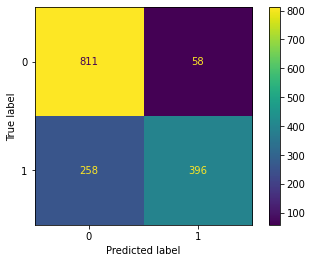

In [3]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import BernoulliNB


cv = CountVectorizer()
cv.fit(train["text"])
train_arr = cv.transform(train["text"])
train_labels = train["target"]
print(f"Bernoulli distribution, p = {train_labels.mean():.2f}")
model = BernoulliNB()
crossval = cross_validate(model, train_arr, train_labels, cv=5, return_estimator=True)
mean_score = crossval["test_score"].mean()
print(f"Mean accuracy on 5-fold cross validation = {mean_score:.2f}")
best_estimator = crossval["estimator"][crossval["test_score"].argmax()]
val_arr = cv.transform(validation["text"])
val_labels = validation["target"]
val_score = best_estimator.score(val_arr, val_labels)
print(f"Validation accuracy = {val_score:.2f}")
cm = plot_confusion_matrix(best_estimator, val_arr, val_labels)

## Approach

To improve the model performance we explore 2 different avenues:

1. How the text data is represented. Specifically we use word embeddings.
2. What type of model is used to learn the relationships between embeddings and the target feature.

Specifically for part 1, the following word embedding schemes are explored:

1. Word2Vec - pretrained
2. Word2Vec - corpus trained

For part 2, based on the results of <a href="https://github.com/MIDS-W207/coursework/blob/master/Readings/Week%2008/An%20Empirical%20Comparison%20of%20Supervised%20Learning%20Algorithms.pdf">this</a> paper comparing the performance of classifiers, we try out the following 3 classifiers:

1. Boosted Trees
2. Support Vector Machines
3. Neural Networks

## Pre-Processing

Since we are using Word Embeddings, we'll need to standardize the format of the input tweets.

In [4]:
import nltk  # For English stopwords.
import re
import string  # For removing punctuation.


nltk.download("stopwords")
STOPWORDS = set(nltk.corpus.stopwords.words("english"))


def preprocess(tweet: str, remove_stopwords: bool = True):
    """Text preprocessing for a single tweet."""
    
    # Convert to lowercase:
    ptweet = tweet.lower()
    
    # Remove all numbers:
    ptweet = re.sub("\d+", " ", ptweet)

    # Replace all punctuation:
    ptweet = re.sub(f"[{string.punctuation}]", " ", ptweet)

    # Remove URLs:
    ptweet = re.sub(r"https?://\S+|www\.\S+", "", ptweet)
    
    if remove_stopwords:
        # Use NLTK to tokenize and remove English stopwords:
        words = nltk.word_tokenize(ptweet)
        words = list(filter(lambda w: w not in STOPWORDS, words))
        return " ".join(words)
    else:
        return " ".join(ptweet.split())

[nltk_data] Downloading package stopwords to /Users/tp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
example_tweet = train["text"][0]
print("Original Tweet:\n", f"  {example_tweet}\n")
print("Processed Tweet, with stopwords:\n", f"{preprocess(example_tweet, remove_stopwords=False)}\n")
print("Processed Tweet, no stopwords:\n", f"{preprocess(example_tweet)}\n")

Original Tweet:
   Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

Processed Tweet, with stopwords:
 our deeds are the reason of this earthquake may allah forgive us all

Processed Tweet, no stopwords:
 deeds reason earthquake may allah forgive us



In [12]:
# Convert full training set to preprocessed formats:
train_pp_nostopw = train["text"].map(preprocess).tolist()
train_pp_stopw = train["text"].map(lambda s: preprocess(s, remove_stopwords=False)).tolist()
val_pp_nostopw = validation["text"].map(preprocess).tolist()
val_pp_stopw = validation["text"].map(lambda s: preprocess(s, remove_stopwords=False)).tolist()

## Word Embeddings

We use word embeddings to convert each word to a $d$-length vector. Because the models we are using require a single vector input, we need a way to then convert the multiple word embeddings for a single tweet into one vector. Using the suggestion <a href="https://stats.stackexchange.com/a/239071/115143">here</a>, we try 2 approaches:

1. Take the simple average of the vectors for all words in the tweet (resulting in vector of length $d$).
2. Concatenate the coordinate-wise minimum and maximum values in each word vector (resulting in vector of length $2d$).

In [7]:
import numpy as np
from gensim.models.keyedvectors import KeyedVectors


class WordEmbeddings:
    
    def __init__(self, X: list, embeddings: KeyedVectors):
        self.X = X
        self.embeddings = embeddings
        
        # Unique vocabulary of the embedding scheme:
        self.embeddings_vocab = set(embeddings.key_to_index)
        
        # Unique vocabulary of the inputs:
        self.X_vocab = {w for words in [s.split() for s in X] for w in words}
        
        # Unknown words in the input:
        self.unknown_words = self.X_vocab - self.embeddings_vocab

        # Common vocabulary between the input and the embeddings scheme:
        self.common_vocab = self.embeddings_vocab & self.X_vocab
        
        # Lookup table from words to their embeddings:
        self.embeddings_table = pd.DataFrame(embeddings[self.common_vocab], index=self.common_vocab).sort_index()
        
        # Iterate through input tweets removing unknown words, creating average/min/max embeddings:
        embedding_mu, embedding_max, embedding_min, clean_tweets = list(), list(), list(), list()
        for i, tweet in enumerate(self.X):
            
            # Remove unknown words:
            words = tweet.split()
            known_words = [w for w in words if w in self.common_vocab]
            clean_tweets.append(" ".join(known_words))
            
            # Calculate mean of all word embeddings in tweet:
            mean_array = self.embeddings_table.loc[known_words].mean().values
            embedding_mu.append(mean_array)
            
            # Calculate min/max of all word embeddings in tweet:
            max_array = self.embeddings_table.loc[known_words].max().values
            embedding_max.append(max_array)
            min_array = self.embeddings_table.loc[known_words].min().values
            embedding_min.append(min_array)
            
        # Arrays of final X datasets in word embedding formats:
        self.embedding_mu = np.array(embedding_mu)
        self.embedding_min = np.array(embedding_min)
        self.embedding_max = np.array(embedding_max)
        
    @property
    def embedding_chars(self):
        """Unique characters in the word embeddings."""
        return "".join(sorted(set([c for w in self.embeddings.index_to_key for c in w])))


### Word2Vec

Using a pretrained Twitter Word2Vec model with ~1.2m word vocabulary:

In [8]:
from gensim import downloader


# Load the pretrained word embeddings:
glove_twitter = downloader.load("glove-twitter-200")
info = downloader.info()
print(info["models"]["glove-twitter-200"]["description"])

Pre-trained vectors based on 2B tweets, 27B tokens, 1.2M vocab, uncased (https://nlp.stanford.edu/projects/glove/).


In [9]:
# Use the WordEmbeddings class to apply the embeddings to the training & validation data:
we_gt = WordEmbeddings(train_pp_stopw, glove_twitter)
we_gt_val = WordEmbeddings(val_pp_stopw, glove_twitter)

In [17]:
from sklearn.neural_network import MLPClassifier

nn_minmax = MLPClassifier(hidden_layer_sizes=100, activation="relu", max_iter=400)
X_embed_minmax = pd.DataFrame(np.concatenate([we_gt.embedding_min, we_gt.embedding_max], axis=1))
nn_minmax.fit(X_embed_minmax, train_labels)
nn_minmax.score(X_embed_minmax, train_labels)

0.9929392446633826

In [18]:
X_val_embed_minmax = pd.DataFrame(np.concatenate([we_gt_val.embedding_min, we_gt_val.embedding_max], axis=1))
nn_minmax.score(X_val_embed_minmax, val_labels)

0.7583716349310571

In [20]:
nn_mu = MLPClassifier(hidden_layer_sizes=100, activation="relu", max_iter=400)
X_embed_mu = pd.DataFrame(we_gt.embedding_mu)
nn_mu.fit(X_embed_mu, train_labels)
nn_mu.score(X_embed_mu, train_labels)

0.9950738916256158

In [21]:
X_val_embed_mu = pd.DataFrame(we_gt_val.embedding_mu)
nn_mu.score(X_val_embed_mu, val_labels)

0.757715036112935

Network is overfitting, so try decreasing iterations and increasing alpha parameter:

In [44]:
nn_minmax = MLPClassifier(hidden_layer_sizes=100, activation="relu", max_iter=50, alpha=0.5)
nn_minmax.fit(X_embed_minmax, train_labels)
nn_minmax.score(X_embed_minmax, train_labels)

/Users/tp/virtualenvs/mids-w207-group-project/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8325123152709359

In [45]:
nn_minmax.score(X_val_embed_minmax, val_labels)

0.7839789888378201

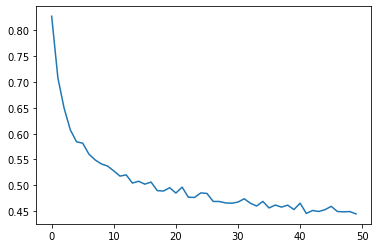

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(nn_minmax.loss_curve_)